# Modelo segmentación

## Consideraciones

$
categoria(nota)= \left\{ \begin{array}{lcc}
             1 & si  & nota \geq 6.0 \\            
             \\ 2 & si & 5.0 \leq nota \leq 5.9\\
             \\ 3 & si & 4.0 \leq nota \leq 4.9\\
             \\ 4 & si & 3.0 \leq nota \leq 3.9\\
             \\ 5 & si & nota \leq 2.9
             \end{array}
   \right.
$

Los candidatos a tutoría serán aquellos que estén en la categoría 4 o 5

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.decomposition import PCA

import matplotlib.cm as cm

## Carga de datos

In [2]:
!wget https://www.dropbox.com/s/3rgq7lu6hivjnue/Simulation_data.csv

--2022-02-11 02:32:40--  https://www.dropbox.com/s/3rgq7lu6hivjnue/Simulation_data.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/3rgq7lu6hivjnue/Simulation_data.csv [following]
--2022-02-11 02:32:41--  https://www.dropbox.com/s/raw/3rgq7lu6hivjnue/Simulation_data.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaeae160e98208ccfba39d5ca5a.dl.dropboxusercontent.com/cd/0/inline/BffrTbVDqPw-lBxGs_IlDSGIOGK1L5QBHkyCgmc_DLS_vMhOLNHiePbzoETl8FzLHaiHqKSkyGRksWkgnws7KbH6Pc6l12MzDX9cQn9UWG84up4tMxhVPkdcuyW2kLr_-S6qhbqJshMbdRowH5Q5CrmJ/file# [following]
--2022-02-11 02:32:41--  https://ucaeae160e98208ccfba39d5ca5a.dl.dropboxusercontent.com/cd/0/inline/BffrTbVDqPw-lBxGs_IlDSGIOGK1L5QBHkyCgmc_DLS_vMhOLNHiePbzoETl8FzLHaiHq

In [3]:
data_frame = pd.read_csv("Simulation_data.csv") 
data_frame.head()

,ID,I1,I2,I3,I4,I5,I6,I7,I8,PUNTAJE,NOTA,CATEGORIA
0,1,1.0,4.0,2.0,2.0,2.0,3.0,2.0,5.0,21.0,3.6,4
1,2,1.0,4.0,2.0,1.0,2.0,3.0,2.0,5.0,20.0,3.5,4
2,3,1.0,1.0,5.0,3.0,2.0,2.0,5.0,3.0,22.0,3.8,4
3,4,5.0,3.0,5.0,5.0,1.0,2.0,5.0,5.0,31.0,5.3,2
4,5,1.0,1.0,5.0,2.0,3.0,3.0,5.0,3.0,23.0,3.9,4


## Análisis exploratorio

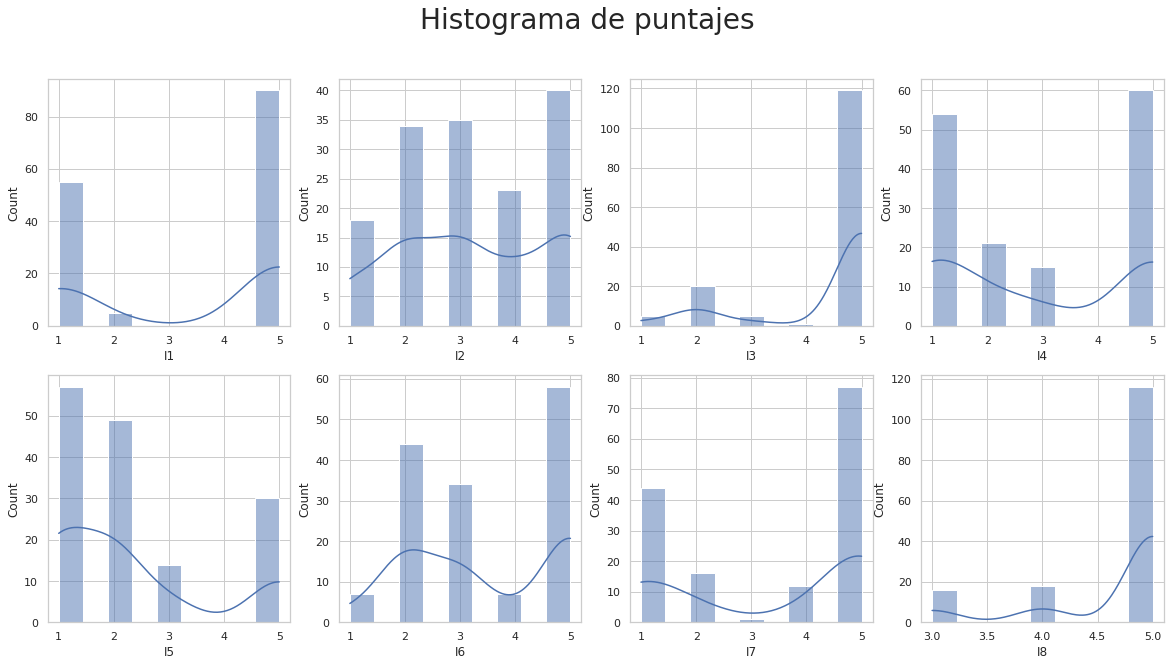

In [121]:
lst_feature = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Histograma de puntajes", fontsize=28)
row, col = 0, 0
for feature in lst_feature:  
  sns.histplot(data_frame[feature], ax=ax[row][col], kde=True) 
  col += 1
  row += 0 if col < 4 else 1
  col = 0 if col > 3 else col
plt.show()

In [6]:
selected = data_frame.columns.difference(['ID', 'CATEGORIA'])
data_frame[selected].describe()

,I1,I2,I3,I4,I5,I6,I7,I8,NOTA,PUNTAJE
count,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,3.433333,3.22000,4.393333,2.940000,2.313333,3.433333,3.413333,4.666667,4.771333,27.813333
std,1.933167,1.37509,1.231012,1.788216,1.479782,1.377756,1.806724,0.662177,1.003038,5.936336
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.100000,17.000000
25%,1.000000,2.00000,5.000000,1.000000,1.000000,2.000000,1.000000,5.000000,3.825000,22.250000
50%,5.000000,3.00000,5.000000,2.500000,2.000000,3.000000,5.000000,5.000000,5.100000,30.000000
75%,5.000000,5.00000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.300000,31.000000
max,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.400000,37.000000


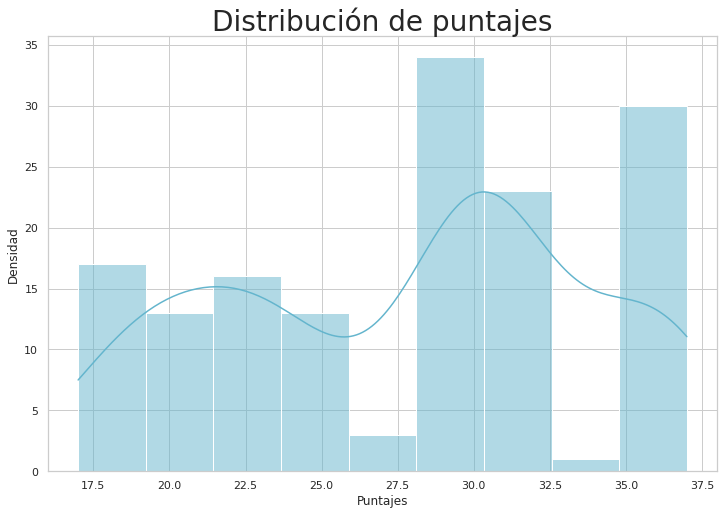

In [122]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.histplot(data_frame['PUNTAJE'], kde = True, color = 'c')
plt.title('Distribución de puntajes', fontsize = 28)
plt.xlabel("Puntajes")
plt.ylabel("Densidad")
plt.show();

In [8]:
data_frame.groupby("CATEGORIA").size()

CATEGORIA
1    30
2    47
3    27
4    46
dtype: int64

## Selección de candidatos a tutoría

In [4]:
data_selected = data_frame.query("CATEGORIA >= 4")
data_selected.shape

(46, 12)

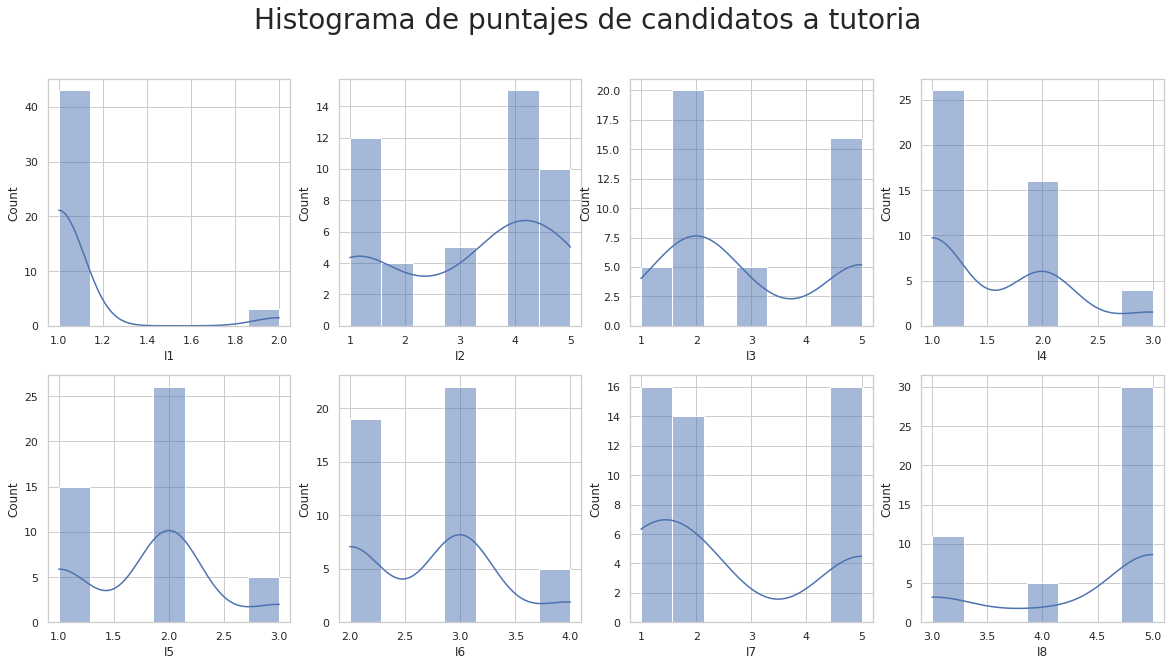

In [120]:
lst_feature = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Histograma de puntajes de candidatos a tutoria", fontsize=28)
row, col = 0, 0
for feature in lst_feature:  
  sns.histplot(data_selected[feature], ax=ax[row][col], kde=True) 
  col += 1
  row += 0 if col < 4 else 1
  col = 0 if col > 3 else col
plt.show()

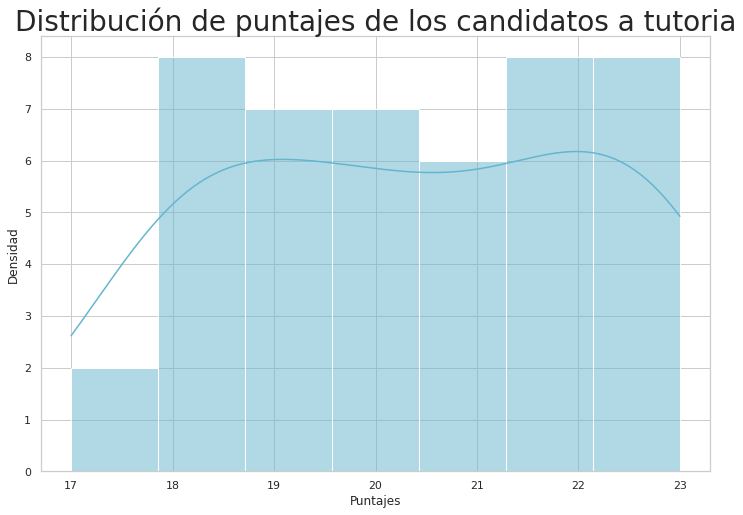

In [124]:
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.histplot(data_selected['PUNTAJE'], kde = True, color = 'c')
plt.title('Distribución de puntajes de los candidatos a tutoria', fontsize = 28)
plt.xlabel("Puntajes")
plt.ylabel("Densidad")
plt.show();

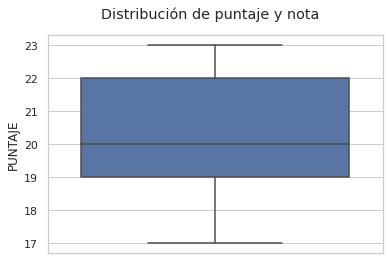

In [133]:
# Revisión de outliers
ax= sns.boxplot(y="PUNTAJE", data=data_selected)
plt.suptitle("Distribución de puntaje y nota");

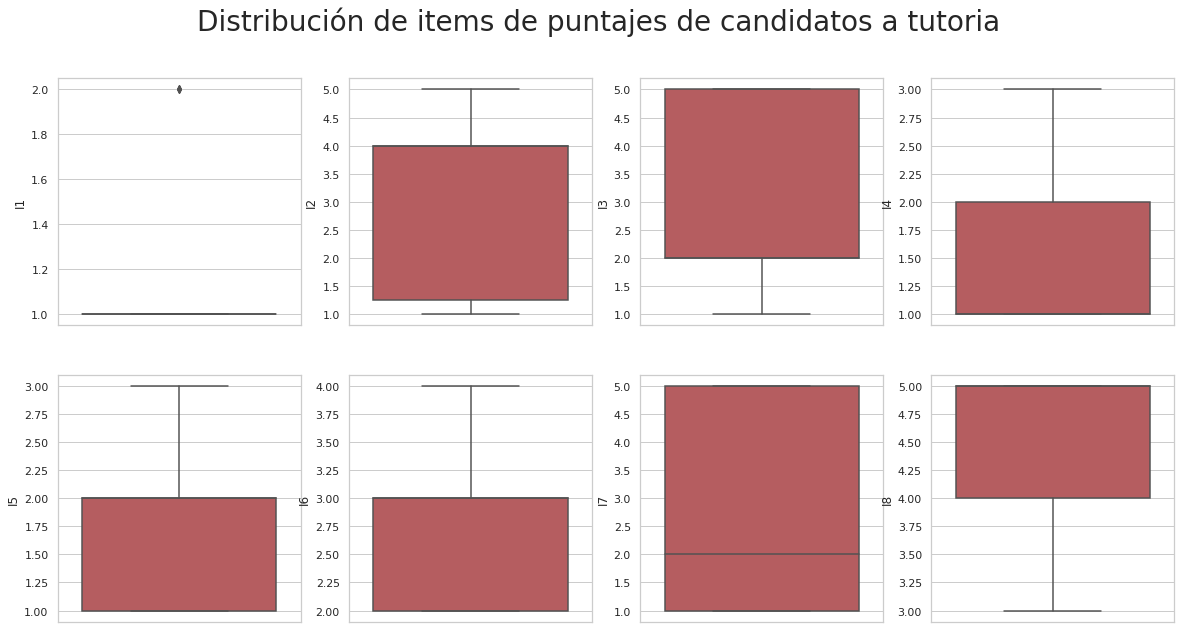

In [141]:
lst_feature = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8']
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Distribución de items de puntajes de candidatos a tutoria", fontsize=28)
row, col = 0, 0
for feature in lst_feature:  
  sns.boxplot(y=data_selected[feature], ax=ax[row][col], data=data_selected, color="r")
  col += 1
  row += 0 if col < 4 else 1
  col = 0 if col > 3 else col
plt.show()

In [10]:
pd.cut(data_selected.NOTA, bins=[1.0,2.0,3.0,4.0]).value_counts()

(3.0, 4.0]    46
(1.0, 2.0]     0
(2.0, 3.0]     0
Name: NOTA, dtype: int64

In [11]:
data_selected.groupby('CATEGORIA')[['PUNTAJE','NOTA']].describe()

PUNTAJE                                   ... NOTA                    
            count       mean       std   min   25%  ...  min  25%  50%  75%  max
CATEGORIA                                           ...                         
4            46.0  20.369565  1.889841  17.0  19.0  ...  3.1  3.4  3.5  3.8  3.9

[1 rows x 16 columns]

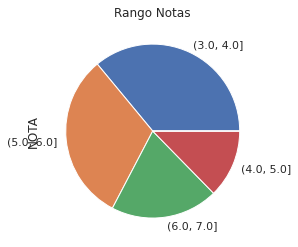

In [14]:
data = pd.cut(data_frame.NOTA, bins=[1.0,2.0,3.0,4.0,5.0,6.0,7.0]).value_counts()
data.plot(kind="pie", title="Rango Notas");

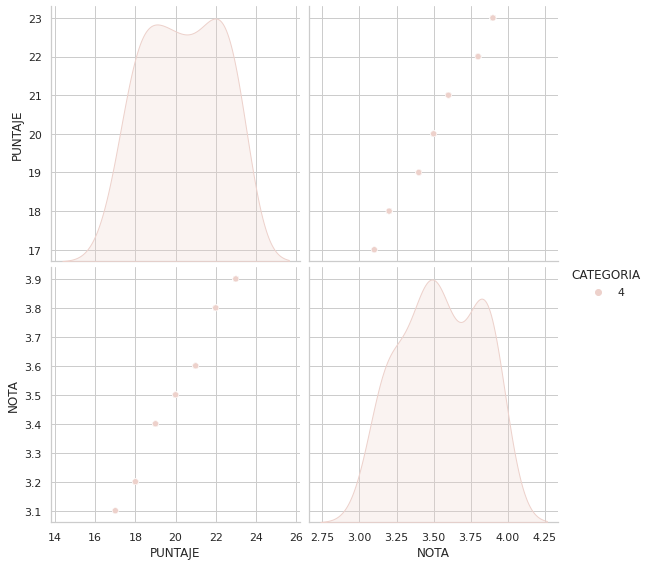

In [15]:
	sns.pairplot(data_selected, hue='CATEGORIA',height=4,vars=["PUNTAJE","NOTA"],kind='scatter');

## Escalado de los datos

In [5]:
lst_include = ["I1","I2","I3","I4","I5","I6","I7","I8"]
exclude = data_selected.columns.difference(lst_include)
X_features = np.array(data_selected[data_selected.columns.drop(exclude)])
y = data_selected.CATEGORIA

In [6]:
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)
print(X_features_scaled.shape)

(46, 8)


## Reducción de la dimensionalidad

El $\textbf{método de componentes principales}$ se usa para explicar la estructura de varianza-covarianzas de una muestra a partir
de unas pocas combinaciones lineales de las variables originales, denominadas $\textit{componentes principales}$

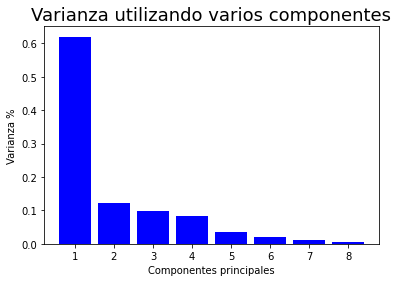

In [7]:
# Plotting the variances for each PC
pca = PCA()
principal_components = pca.fit_transform(X_features_scaled)
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='blue')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza %')
plt.xticks(PC)
plt.title("Varianza utilizando varios componentes", fontsize=18)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principal_components)

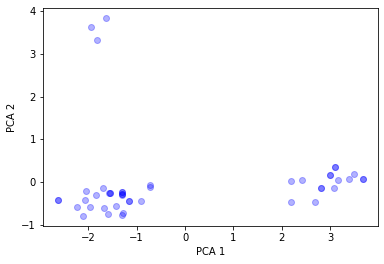

In [8]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [9]:
def cluster_by_PCA(n_pca):
  inertias = []

  # Creating 10 K-Mean models while varying the number of clusters (k)
  for k in range(2,10):
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:n_pca])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
  plt.plot(range(2,10), inertias, '-p', color='red')
  plt.xlabel('Número de cluster, k')
  plt.ylabel('inercia')
  plt.title('Variación de inercias usando PCA {}'.format(n_pca))
  plt.show()

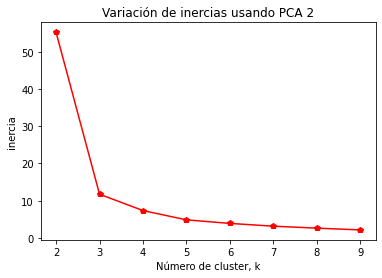

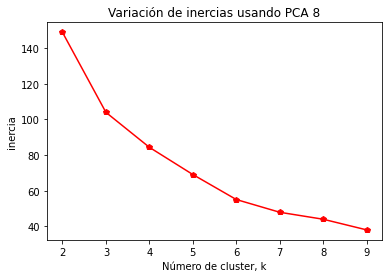

In [10]:
cluster_by_PCA(2); cluster_by_PCA(8); 

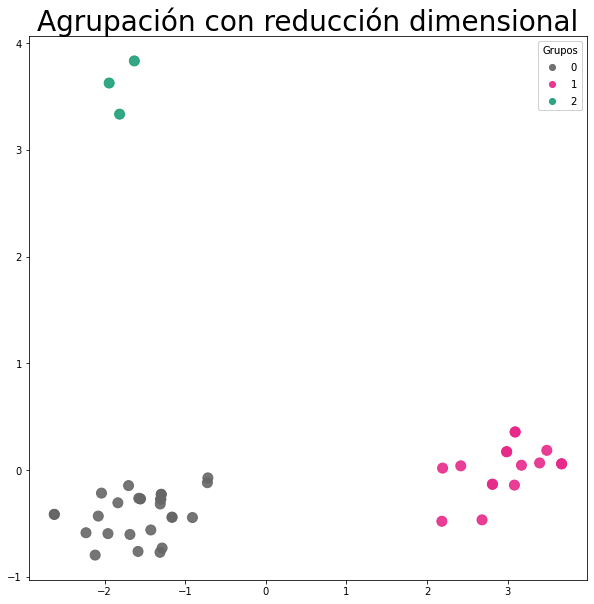

In [11]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])
fig, ax = plt.subplots(figsize=(10,10))
labels = model.predict(PCA_components.iloc[:,:2])
scatter = ax.scatter(PCA_components[0], PCA_components[1], c=labels, cmap="Dark2_r", s=100, alpha=0.9)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Grupos")
ax.add_artist(legend1)
plt.title("Agrupación con reducción dimensional",fontsize=28)
plt.show()

In [12]:
data_final = data_selected.copy()
data_final['grupo'] = labels
data_final

,ID,I1,I2,I3,I4,I5,I6,I7,I8,PUNTAJE,NOTA,CATEGORIA,grupo
0,1,1.0,4.0,2.0,2.0,2.0,3.0,2.0,5.0,21.0,3.6,4,0
1,2,1.0,4.0,2.0,1.0,2.0,3.0,2.0,5.0,20.0,3.5,4,0
2,3,1.0,1.0,5.0,3.0,2.0,2.0,5.0,3.0,22.0,3.8,4,1
4,5,1.0,1.0,5.0,2.0,3.0,3.0,5.0,3.0,23.0,3.9,4,1
8,9,1.0,1.0,5.0,2.0,2.0,3.0,5.0,4.0,23.0,3.9,4,1
12,13,1.0,3.0,1.0,1.0,2.0,3.0,2.0,5.0,18.0,3.2,4,0
15,16,1.0,1.0,5.0,3.0,2.0,2.0,5.0,4.0,23.0,3.9,4,1
17,18,1.0,4.0,2.0,1.0,2.0,3.0,2.0,5.0,20.0,3.5,4,0
19,20,1.0,2.0,5.0,2.0,2.0,3.0,5.0,3.0,23.0,3.9,4,1
21,22,1.0,5.0,2.0,2.0,1.0,4.0,1.0,5.0,21.0,3.6,4,0


In [38]:
data_final.groupby('grupo').count()

,ID,I1,I2,I3,I4,I5,I6,I7,I8,PUNTAJE,NOTA,CATEGORIA
grupo,,,,,,,,,,,,
0,27,27,27,27,27,27,27,27,27,27,27,27
1,16,16,16,16,16,16,16,16,16,16,16,16
2,3,3,3,3,3,3,3,3,3,3,3,3


## Obtención de número óptimo de clusters

### Curva de elbow



In [13]:
def get_cluster_elbow(n_pca, max_clusters = 11, algorithm = None):
  """
  Método curva de elbow para identificar el número óptimo de clusters
  """  
  num_clusters = range(2, max_clusters)
  x_algorithm = "auto" if algorithm is None else algorithm
  models = [KMeans(n_clusters=i, random_state=29, algorithm=x_algorithm) for i in num_clusters]
  score = [models[i].fit(PCA_components.iloc[:,:n_pca]).score(PCA_components.iloc[:,:n_pca]) for i in range(len(models))] 
  inercias = [models[i].inertia_ for i in range(len(models))] 

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].plot(num_clusters, inercias, marker='o')
  ax[0].set_title("Evolución de la varianza intra-cluster total")
  ax[0].set_xlabel('Número clusters')
  ax[0].set_ylabel('Intra-cluster (inertia)');

  ax[1].plot(num_clusters,score)
  ax[1].grid(color='r', linestyle='dotted', linewidth=1)
  ax[1].set_title("Evolución del score total")
  ax[1].set_xlabel('Número de Clusters')
  ax[1].set_ylabel('Score')

  plt.show()



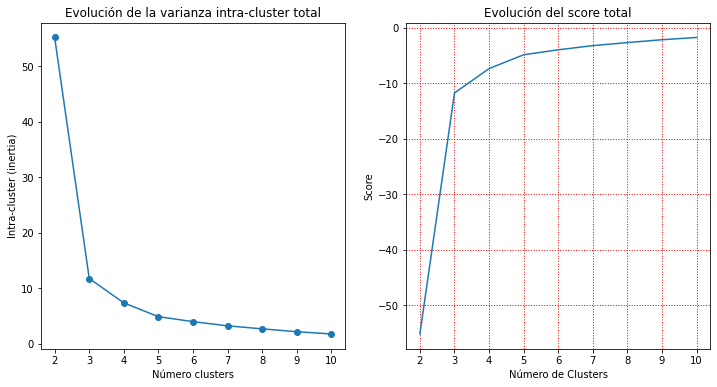

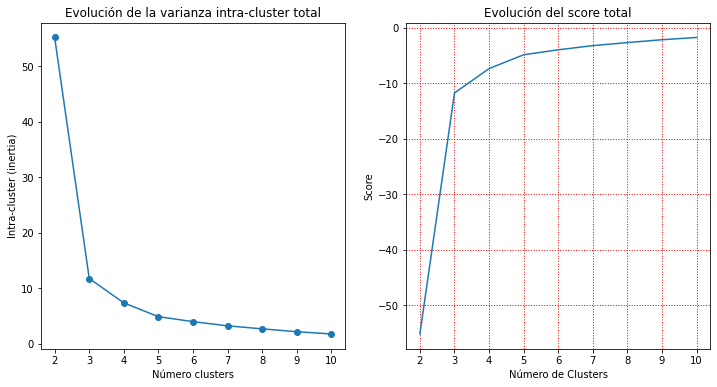

In [15]:
for alg in ['auto', 'elkan']:
  get_cluster_elbow(2,algorithm=alg)

### Método silhouette

In [28]:
def get_cluster_silhoutte(n_pca, max_clusters = 11, algorithm = None):
  """
  Método silhouette para identificar el número óptimo de clusters
  """
  range_n_clusters = range(2, max_clusters)
  valores_medios_silhouette = []

  x_algorithm = "auto" if algorithm is None else algorithm
  for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        random_state = 123, 
                        algorithm = x_algorithm
                    )
    cluster_labels = modelo_kmeans.fit_predict(PCA_components.iloc[:,:n_pca])
    silhouette_avg = silhouette_score(PCA_components.iloc[:,:n_pca], cluster_labels, metric="sqeuclidean")
    valores_medios_silhouette.append(silhouette_avg)
  return list(range(2,max_clusters))[np.argmax(valores_medios_silhouette)], valores_medios_silhouette, range_n_clusters

def graphic_view(range_clusters, values, algorithm):
  fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
  ax.plot(range_clusters, values, marker='o')
  ax.set_title("Evolución de media de los índices silhouette con {}".format(algorithm))
  ax.set_xlabel('Número clusters')
  ax.set_ylabel('Media índices silhouette');


Cluster ideal, usando índices silhouette con algoritmo auto es 3
Cluster ideal, usando índices silhouette con algoritmo elkan es 3


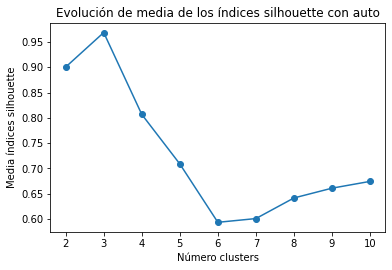

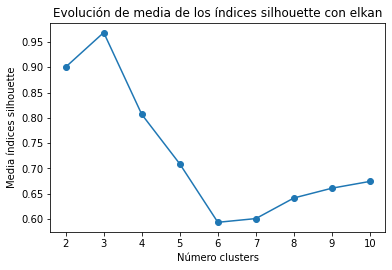

In [29]:
for alg in ['auto', 'elkan']:
  ideal_number, values, rc = get_cluster_silhoutte(2)
  print("Cluster ideal, usando índices silhouette con algoritmo {0} es {1}".format(alg, ideal_number))
  graphic_view(rc, values, alg)

Cluster ideal = 3
 usando índices silhouette con parámetros
 algoritmo auto y N_PCA 8
Cluster ideal = 3
 usando índices silhouette con parámetros
 algoritmo elkan y N_PCA 8


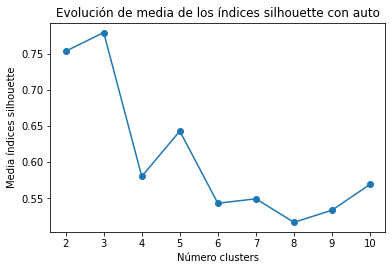

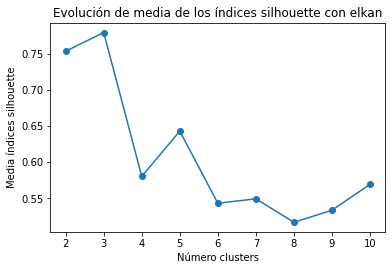

In [30]:
n_pca = 8
for alg in ['auto', 'elkan']:
  ideal_number, values, rc = get_cluster_silhoutte(n_pca)
  print("Cluster ideal = {1}\n usando índices silhouette con parámetros\n algoritmo {0} y N_PCA {2}".format(alg, ideal_number, n_pca))
  graphic_view(rc, values, alg)

### Estadístico de GAP

In [17]:
def get_cluster_GAP(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
      # Holder for reference dispersion results
      refDisps = np.zeros(nrefs)
      # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
      for i in range(nrefs):      
        # Create new random reference set
        randomReference = np.random.random_sample(size=data.shape)
        # Fit to it
        km = KMeans(k)
        km.fit(randomReference)
        refDisp = km.inertia_
        refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


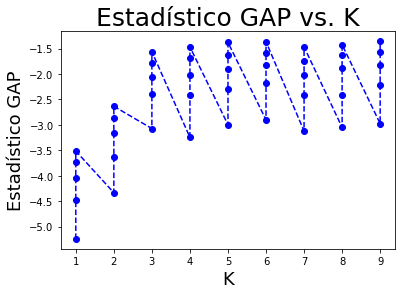

In [20]:
score_g, df = get_cluster_GAP(PCA_components.iloc[:,:2], nrefs=5, maxClusters=10)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize=18);
plt.ylabel('Estadístico GAP', fontsize=18);
plt.title('Estadístico GAP vs. K', fontsize=25);


## Generación del modelo

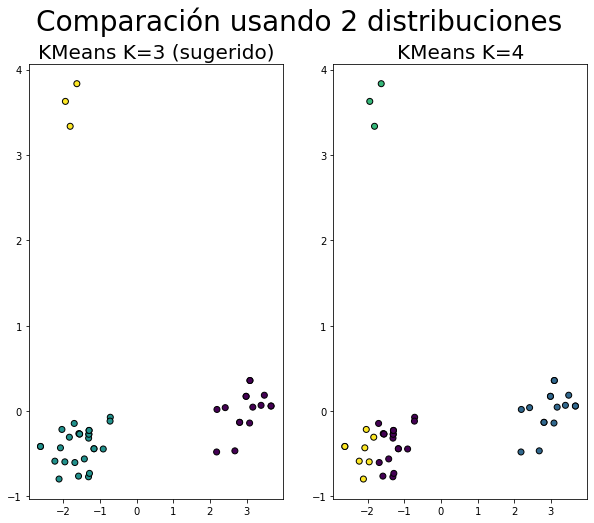

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
x_algorithm = 'auto'
# Resultados para K = valor ideal de acuerdo a los métodos anteriores
# ==============================================================================
modelo_kmeans = KMeans(n_clusters = ideal_number, random_state=29, 
                       algorithm = x_algorithm).fit(X=PCA_components.iloc[:,:2])
y_predict_a = modelo_kmeans.predict(PCA_components.iloc[:,:2])

ax[0].scatter(
        x = PCA_components[0],
        y = PCA_components[1], 
        c = y_predict_a,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[0].set_title('KMeans K={} (sugerido)'.format(ideal_number), fontsize=20);

# Resultados para K = una unidad más de la propuesta ideal
# ==============================================================================

y_predict_b = KMeans(n_clusters=ideal_number+1, random_state=29, 
                     algorithm = x_algorithm).fit_predict(X=PCA_components.iloc[:,:2])
ax[1].scatter(
        x = PCA_components[0],
        y = PCA_components[1], 
        c = y_predict_b,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[1].set_title('KMeans K={}'.format(ideal_number+1), fontsize=20)
plt.suptitle("Comparación usando 2 distribuciones", fontsize=28)
plt.show()

In [24]:
pd.DataFrame(y_predict_a, columns=['grupo']).groupby("grupo").size()

grupo
0    16
1    27
2     3
dtype: int64

## Evaluación usando el coeficiente de Silhouette

In [27]:
print(
    "Silhouette Coefficient: %0.3f"
    % silhouette_score(PCA_components.iloc[:,:2], y_predict_a, metric="sqeuclidean")
)

print(
    "Silhouette Coefficient with euclidian: %0.3f"
    % silhouette_score(PCA_components.iloc[:,:2], y_predict_a)
)

Silhouette Coefficient: 0.969
Silhouette Coefficient with euclidian: 0.848


The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

## Análisis de clusters

### Funciones

In [74]:
def get_data_final(data, y_predict):
  data_final = data.copy()
  data_final['GRUPO'] = y_predict
  data_final['total'] = 1
  return data_final

In [75]:
def get_selected_features(data, features_selected = ['ID', 'GRUPO', 'NOTA']):
  return data[features_selected]

def get_clusters(data):
  return data['GRUPO'].unique()

In [76]:
def get_total_by_cluster(data):
  return data.groupby('GRUPO')[['total']].sum()

In [77]:
def get_metrics_by_cluster(data, columns, metrics):
  return data.groupby('GRUPO')[columns].aggregate(metrics)

In [78]:
def get_summary_cluster(data, cluster, selected):
  return data[data.GRUPO == cluster][selected]

### Obtener grupos

In [79]:
data_final_x = get_data_final(data_selected, y_predict_a)
data_final_y = get_data_final(data_selected, y_predict_b)

### Ver resultados

In [81]:
get_selected_features(data_final_x)

,ID,GRUPO,NOTA
0,1,1,3.6
1,2,1,3.5
2,3,0,3.8
4,5,0,3.9
8,9,0,3.9
12,13,1,3.2
15,16,0,3.9
17,18,1,3.5
19,20,0,3.9
21,22,1,3.6


In [82]:
print(get_clusters(data_final_x))
print(get_clusters(data_final_y))

[1 0 2]
[0 1 3 2]


In [205]:
lst_features_selected = ['ID', 'GRUPO']
df_merge = pd.merge(data_final_x[lst_features_selected], data_final_y[lst_features_selected], how='inner', on='ID')
df_merge['equals'] = df_merge.apply(lambda x : x.GRUPO_x == x.GRUPO_y, axis=1)
df_merge

,ID,GRUPO_x,GRUPO_y,equals
0,1,1,0,False
1,2,1,0,False
2,3,0,1,False
3,5,0,1,False
4,9,0,1,False
5,13,1,0,False
6,16,0,1,False
7,18,1,0,False
8,20,0,1,False
9,22,1,3,False


In [83]:
get_total_by_cluster(data_final_x)

,total
GRUPO,
0,16
1,27
2,3


In [192]:
get_total_by_cluster(data_final_y)

,total
GRUPO,
0,19
1,16
2,3
3,8


In [85]:
lst_metrics = [np.mean, np.median, np.max, np.min]
get_metrics_by_cluster(data_final_y, lst_include, lst_metrics)

I1                         I2         ...   I7           I8                 
      mean median amax amin      mean median  ... amax amin    mean median amax amin
GRUPO                                         ...                                   
0      1.0    1.0  1.0  1.0  4.000000    4.0  ...  2.0  1.0  5.0000    5.0  5.0  5.0
1      1.0    1.0  1.0  1.0  1.250000    1.0  ...  5.0  5.0  3.3125    3.0  4.0  3.0
2      2.0    2.0  2.0  2.0  4.333333    4.0  ...  2.0  1.0  5.0000    5.0  5.0  5.0
3      1.0    1.0  1.0  1.0  4.500000    5.0  ...  1.0  1.0  5.0000    5.0  5.0  5.0

[4 rows x 32 columns]

In [87]:
df_pivot = data_final_x.pivot_table(values='NOTA', index='GRUPO',  aggfunc = [np.median, np.mean])
df_pivot = df_pivot.unstack().reset_index()
df_pivot.columns = ['metric','feature','group','value']

In [88]:
df_pivot

,metric,feature,group,value
0,median,NOTA,0,3.850000
1,median,NOTA,1,3.400000
2,median,NOTA,2,3.600000
3,mean,NOTA,0,3.806250
4,mean,NOTA,1,3.388889
5,mean,NOTA,2,3.633333


In [89]:
get_summary_cluster(data_final_x, 0, selected)

,I1,I2,I3,I4,I5,I6,I7,I8,NOTA,PUNTAJE
2,1.0,1.0,5.0,3.0,2.0,2.0,5.0,3.0,3.8,22.0
4,1.0,1.0,5.0,2.0,3.0,3.0,5.0,3.0,3.9,23.0
8,1.0,1.0,5.0,2.0,2.0,3.0,5.0,4.0,3.9,23.0
15,1.0,1.0,5.0,3.0,2.0,2.0,5.0,4.0,3.9,23.0
19,1.0,2.0,5.0,2.0,2.0,3.0,5.0,3.0,3.9,23.0
33,1.0,1.0,5.0,2.0,1.0,2.0,5.0,4.0,3.6,21.0
37,1.0,1.0,5.0,2.0,3.0,2.0,5.0,4.0,3.9,23.0
38,1.0,2.0,5.0,3.0,2.0,2.0,5.0,3.0,3.9,23.0
45,1.0,2.0,5.0,2.0,2.0,2.0,5.0,3.0,3.8,22.0
49,1.0,1.0,5.0,3.0,2.0,2.0,5.0,3.0,3.8,22.0


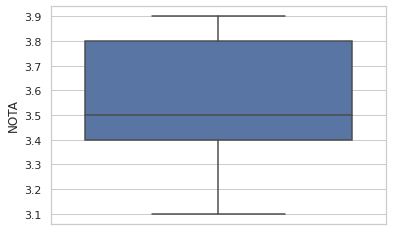

In [103]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y='NOTA', data= data_final_x)

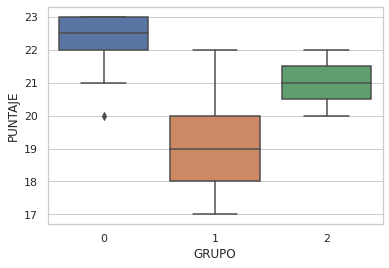

In [93]:
ax = sns.boxplot(x="GRUPO", y="PUNTAJE", data=data_final_x)

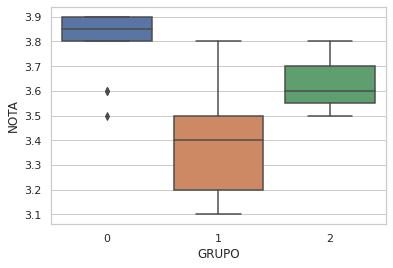

In [94]:
ax = sns.boxplot(x="GRUPO", y="NOTA", data=data_final_x)

In [97]:
def get_describe_by_cluster(data, cluster, selected):
  return data[data.GRUPO == cluster][selected].describe()

In [98]:
for cluster in np.sort(get_clusters(data_final_x)):
  print("Summary cluster {}".format(cluster))
  print(get_describe_by_cluster(data_final_y, cluster, ['NOTA', 'PUNTAJE']))

Summary cluster 0
            NOTA    PUNTAJE
count  19.000000  19.000000
mean    3.410526  19.315789
std     0.199707   1.416280
min     3.100000  17.000000
25%     3.200000  18.000000
50%     3.400000  19.000000
75%     3.500000  20.000000
max     3.800000  22.000000
Summary cluster 1
            NOTA    PUNTAJE
count  16.000000  16.000000
mean    3.806250  22.250000
std     0.128938   0.930949
min     3.500000  20.000000
25%     3.800000  22.000000
50%     3.850000  22.500000
75%     3.900000  23.000000
max     3.900000  23.000000
Summary cluster 2
           NOTA  PUNTAJE
count  3.000000      3.0
mean   3.633333     21.0
std    0.152753      1.0
min    3.500000     20.0
25%    3.550000     20.5
50%    3.600000     21.0
75%    3.700000     21.5
max    3.800000     22.0


## Guarda resultados

In [191]:
for n_grupo in data_final_x.GRUPO.unique():
  data_final_x[data_final_x.GRUPO == n_grupo][['ID','NOTA']].to_csv("Grupo_{}.csv".format(n_grupo), index=False)

In [193]:
for n_grupo in data_final_y.GRUPO.unique():
  data_final_y[data_final_y.GRUPO == n_grupo][['ID','NOTA']].to_csv("Grupo_{}_B.csv".format(n_grupo), index=False)

## Comparación de modelos

For n_clusters = 2 The average silhouette_score is : 0.9003971803525429
For n_clusters = 3 The average silhouette_score is : 0.9686780831231749
For n_clusters = 4 The average silhouette_score is : 0.8068453806807988
For n_clusters = 5 The average silhouette_score is : 0.7088267288932542
For n_clusters = 6 The average silhouette_score is : 0.6709502013050695


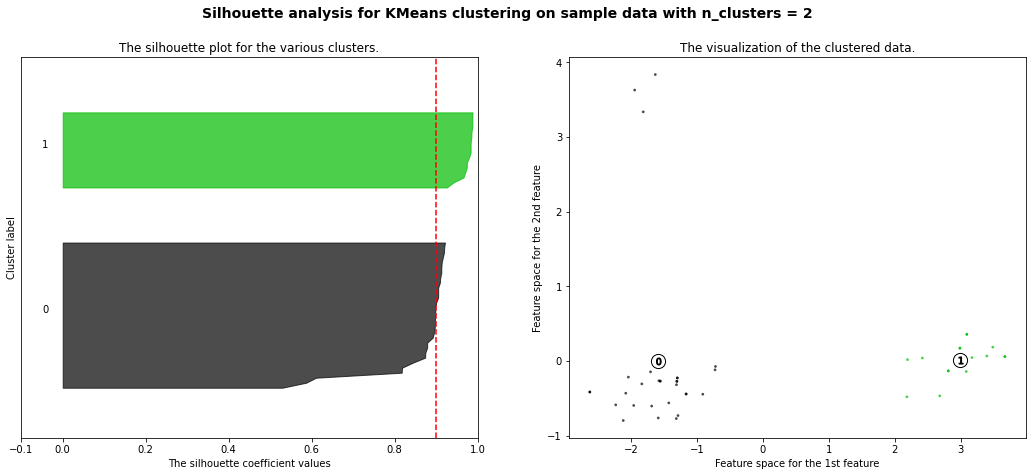

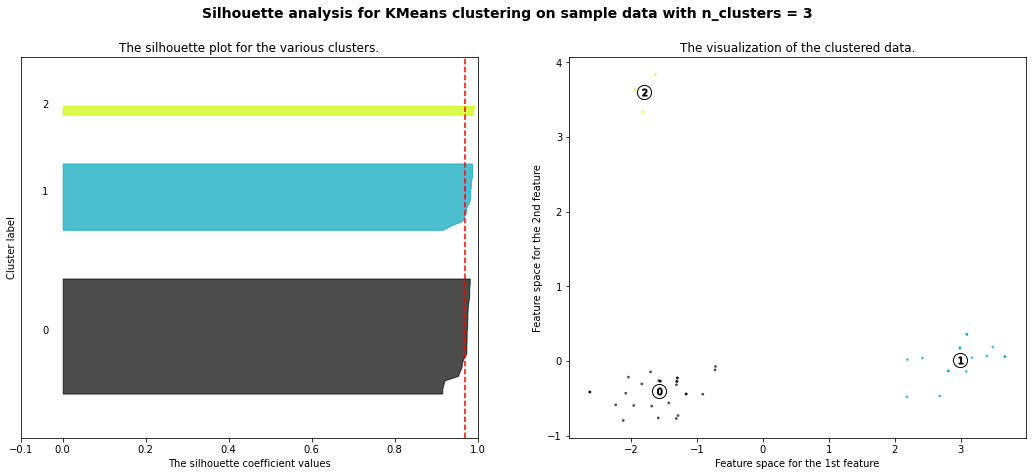

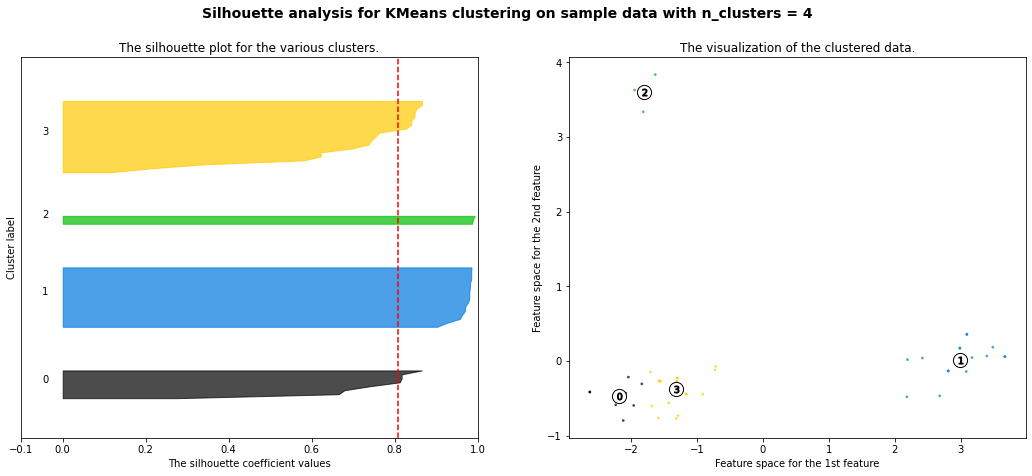

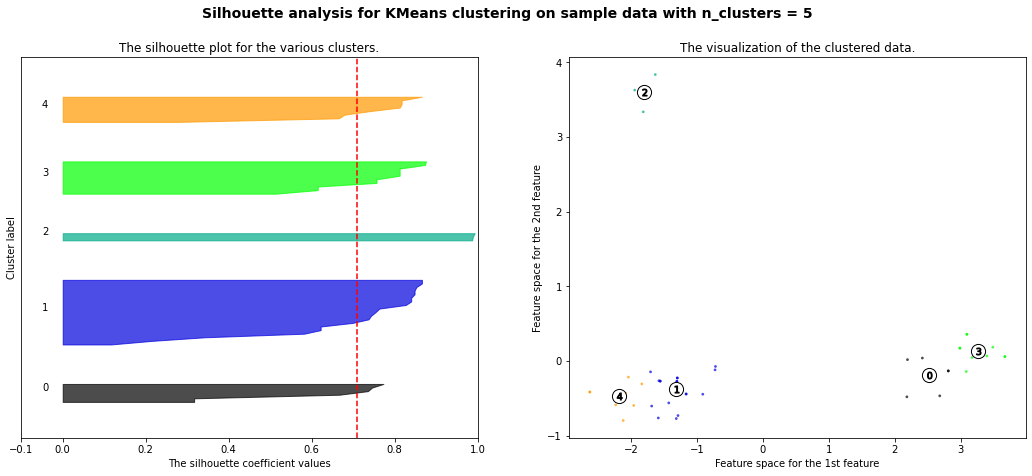

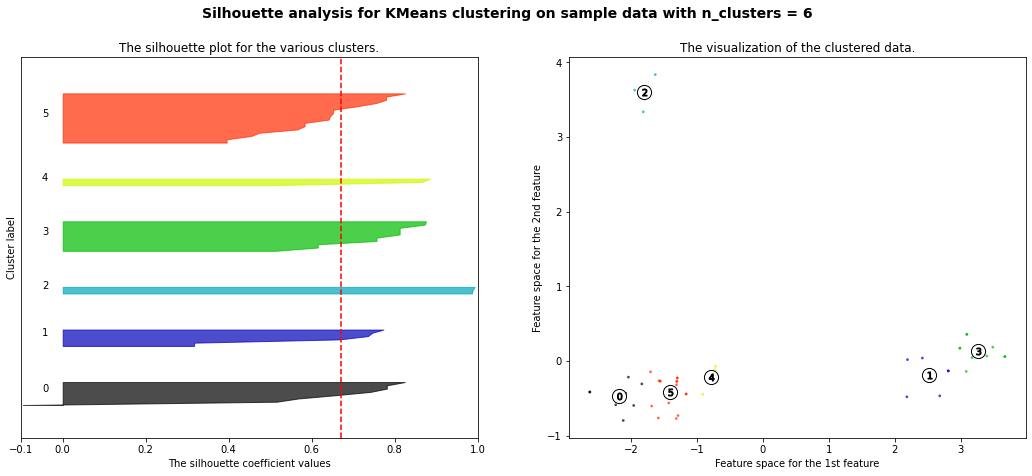

In [35]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(PCA_components.iloc[:,:2]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(PCA_components.iloc[:,:2])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(PCA_components.iloc[:,:2], cluster_labels, 
                                      metric="sqeuclidean")
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(PCA_components.iloc[:,:2], cluster_labels, 
                                                  metric="sqeuclidean")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        PCA_components[0], PCA_components[1], marker=".", s=30, lw=0, alpha=0.7, 
        c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ddaaf58-075e-4191-8bbb-dc9543aea97c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>